# Setup 

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

In [4]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-69ee557d-28be-4359-a171-21bb4dfa0142;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 405ms :: artifacts dl 35ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/10 03:14:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [5]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)

# Create or retrieve a Spark session
spark = SparkSession.builder.appName("ReadS3Parquet").getOrCreate()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker-us-east-1-433974840707
23/11/10 03:14:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Data

In [23]:
# S3 directory path
s3_directory = f"s3a://{bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_comments_centrist_libertarian = spark.read.parquet(s3_directory)

In [24]:
# S3 directory path
s3_directory = f"s3a://{bucket}/project/cleaned/submissions/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_centrist_libertarian = spark.read.parquet(s3_directory)

# Importing Data for other Subreddits 

In [25]:
# Tegveer subreddits
anthony_bucket = 'sagemaker-us-east-1-711387073580'
s3_directory_anthony_submissions = f"s3a://{anthony_bucket}/project/cleaned/submissions/"
s3_directory_anthony_comments = f"s3a://{anthony_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_askpolitics_changemyview = spark.read.parquet(s3_directory_anthony_submissions)
df_comments_askpolitics_changemyview = spark.read.parquet(s3_directory_anthony_comments)


In [26]:
# Eric subreddits
eric_bucket = 'sagemaker-us-east-1-395393721134'
s3_directory_eric_submissions = f"s3a://{eric_bucket}/project/cleaned/submissions/"
s3_directory_eric_comments = f"s3a://{eric_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_socialism_economics_liberal = spark.read.parquet(s3_directory_eric_submissions)
df_comments_socialism_economics_liberal = spark.read.parquet(s3_directory_eric_comments)

In [27]:
# Raunak subreddits

raunak_bucket = 'sagemaker-us-east-1-224518912016'
s3_directory_raunak_submissions = f"s3a://{raunak_bucket}/project/cleaned/submissions/"
s3_directory_raunak_comments = f"s3a://{raunak_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_conservative_finance = spark.read.parquet(s3_directory_raunak_submissions)
df_comments_conservative_finance = spark.read.parquet(s3_directory_raunak_comments)

# EDA - Submissions Cosine Similarity and Jaccard Index for Grouped Subreddits (Politics & Economics)

In [6]:
import pyspark.sql.functions as f
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

## Economics Word List

### Title

In [62]:
word_list_econ = ["recession", "inflation", "unemployment", "crypto", "blockchain", "nft"]

# Regular expression pattern to match words not in the list of words_to_keep

word_list_econ_pattern = "|".join(word_list_econ)

df_submissions_finance = df_submissions_conservative_finance.filter(col("subreddit")=="finance")
df_submissions_economics = df_submissions_socialism_economics_liberal.filter(col("subreddit")=="Economics")
df_submissions_conservative = df_submissions_conservative_finance.filter(col("subreddit")=="Conservative")
df_submissions_socialism_liberal = df_submissions_socialism_economics_liberal.filter(col("subreddit")!="Economics")

df_submissions_pol = df_submissions_centrist_libertarian.union(df_submissions_conservative)
df_submissions_pol = df_submissions_pol.union(df_submissions_socialism_liberal)

# rename all political subreddits to politics for later groupby

df_submissions_pol = df_submissions_pol.withColumn("subreddit", f.lit("politics"))

# rename all econ subreddits to economics for later groupby

df_submissions_econ = df_submissions_finance.union(df_submissions_economics)

df_submissions_econ = df_submissions_econ.withColumn("subreddit", f.lit("economics"))

# Lowercase the selftext column for both df_submissions_pol and df_submissions_econ
df_submissions_pol = df_submissions_pol.withColumn("title_lowered", f.lower(col("title")))
df_submissions_econ = df_submissions_econ.withColumn("title_lowered", f.lower(col("title")))

# Filter selftext_lowered for df_submissions_pol using regex
df_submissions_pol_wle = df_submissions_pol.filter(col("title_lowered").rlike(word_list_econ_pattern))

# Filter selftext_lowered for df_submissions_econ using regex
df_submissions_econ_wle = df_submissions_econ.filter(col("title_lowered").rlike(word_list_econ_pattern))

# User-defined function to filter words
def filter_words(text):
    words = text.split()
    filtered_words = [word for word in words if word in word_list_econ]
    return ' '.join(filtered_words)

# Register UDF
filter_words_udf = f.udf(filter_words, StringType())

# Apply UDF to each df
df_submissions_pol_wle = df_submissions_pol_wle.withColumn("title_filtered", filter_words_udf(col("title_lowered")))
df_submissions_econ_wle = df_submissions_econ_wle.withColumn("title_filtered", filter_words_udf(col("title_lowered")))

# Sanity check to remove any non-matching rows
df_submissions_pol_wle = df_submissions_pol_wle.filter(col("title_filtered")!='')
df_submissions_econ_wle = df_submissions_econ_wle.filter(col("title_filtered")!='')

# Combine both dataframes to create pivoted table
df_combined = df_submissions_pol_wle.union(df_submissions_econ_wle)

# Apply regex pattern and count occurrences of words in word_list_econ for each subreddit
df_combined = df_combined.withColumn("list_word", f.split(col('title_filtered'), ' '))
df_combined = df_combined.withColumn("word", f.explode(col('list_word')))
df_combined_word_counts = df_combined.groupBy("subreddit", "word").agg(f.count("*").alias("wordCount"))

# Pivot the DataFrame to get total counts for each word by subreddit
df_pivoted = df_combined_word_counts.groupBy("subreddit").pivot("word").agg(f.sum("wordCount"))

df_pivoted.show()

# convert to pandas df
df_pivoted = df_pivoted.toPandas()
df_pivoted.to_csv('../../data/csv/econ_word_counts_grouped_subreddits_title.csv', index=False)

# convert back to pyspark df
df_pivoted = spark.createDataFrame(df_pivoted)

+---------+----------+------+---------+---+---------+------------+
|subreddit|blockchain|crypto|inflation|nft|recession|unemployment|
+---------+----------+------+---------+---+---------+------------+
| politics|        59|   462|     3195|256|      437|         448|
|economics|       224|  1365|     2350|156|      637|         302|
+---------+----------+------+---------+---+---------+------------+



In [64]:
def cosine_similarity_calc(vec_1,vec_2):
	
	sim = np.dot(vec_1,vec_2)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2))
	
	return sim

pol_vec = df_pivoted.filter(col("subreddit") == "politics").select("recession", "inflation", "unemployment", "crypto", "blockchain", "nft").rdd.flatMap(lambda x: x).collect()
econ_vec = df_pivoted.filter(col("subreddit") == "economics").select("recession", "inflation", "unemployment", "crypto", "blockchain", "nft").rdd.flatMap(lambda x: x).collect()

cosine_sim_econ_grouped_subreddits_title = cosine_similarity_calc(pol_vec,econ_vec)

print('Cosine smilarity:', cosine_sim_econ_grouped_subreddits_title)

Cosine smilarity: 0.9248006097149873


In [66]:
# Calculate Jaccard Similarity

def jaccard_index(counts1, counts2):
  """Calculates the Jaccard index between two vectors of counts."""

  intersection = np.sum(np.minimum(counts1, counts2))
  union = np.sum(np.maximum(counts1, counts2))

  return intersection / union

# Calculate the Jaccard index between the two documents
jaccard_index_econ_grouped_subreddits_title = jaccard_index(pol_vec, econ_vec)

# Print the Jaccard index
print('Jaccard smilarity:', jaccard_index_econ_grouped_subreddits_title)

Jaccard smilarity: 0.6148571428571429


### Body

In [67]:
word_list_econ = ["recession", "inflation", "unemployment", "crypto", "blockchain", "nft"]

# Regular expression pattern to match words not in the list of words_to_keep

word_list_econ_pattern = "|".join(word_list_econ)

df_submissions_finance = df_submissions_conservative_finance.filter(col("subreddit")=="finance")
df_submissions_economics = df_submissions_socialism_economics_liberal.filter(col("subreddit")=="Economics")
df_submissions_conservative = df_submissions_conservative_finance.filter(col("subreddit")=="Conservative")
df_submissions_socialism_liberal = df_submissions_socialism_economics_liberal.filter(col("subreddit")!="Economics")

df_submissions_pol = df_submissions_centrist_libertarian.union(df_submissions_conservative)
df_submissions_pol = df_submissions_pol.union(df_submissions_socialism_liberal)

# rename all political subreddits to politics for later groupby

df_submissions_pol = df_submissions_pol.withColumn("subreddit", f.lit("politics"))

# rename all econ subreddits to economics for later groupby

df_submissions_econ = df_submissions_finance.union(df_submissions_economics)

df_submissions_econ = df_submissions_econ.withColumn("subreddit", f.lit("economics"))

# Lowercase the selftext column for both df_submissions_pol and df_submissions_econ
df_submissions_pol = df_submissions_pol.withColumn("selftext_lowered", f.lower(col("selftext")))
df_submissions_econ = df_submissions_econ.withColumn("selftext_lowered", f.lower(col("selftext")))

# Filter selftext_lowered for df_submissions_pol using regex
df_submissions_pol_wle = df_submissions_pol.filter(col("selftext_lowered").rlike(word_list_econ_pattern))

# Filter selftext_lowered for df_submissions_econ using regex
df_submissions_econ_wle = df_submissions_econ.filter(col("selftext_lowered").rlike(word_list_econ_pattern))

# User-defined function to filter words
def filter_words(text):
    words = text.split()
    filtered_words = [word for word in words if word in word_list_econ]
    return ' '.join(filtered_words)

# Register UDF
filter_words_udf = f.udf(filter_words, StringType())

# Apply UDF to each df
df_submissions_pol_wle = df_submissions_pol_wle.withColumn("selftext_filtered", filter_words_udf(col("selftext_lowered")))
df_submissions_econ_wle = df_submissions_econ_wle.withColumn("selftext_filtered", filter_words_udf(col("selftext_lowered")))

# Sanity check to remove any non-matching rows
df_submissions_pol_wle = df_submissions_pol_wle.filter(col("selftext_filtered")!='')
df_submissions_econ_wle = df_submissions_econ_wle.filter(col("selftext_filtered")!='')

# Combine both dataframes to create pivoted table
df_combined = df_submissions_pol_wle.union(df_submissions_econ_wle)

# Apply regex pattern and count occurrences of words in word_list_econ for each subreddit
df_combined = df_combined.withColumn("list_word", f.split(col('selftext_filtered'), ' '))
df_combined = df_combined.withColumn("word", f.explode(col('list_word')))
df_combined_word_counts = df_combined.groupBy("subreddit", "word").agg(f.count("*").alias("wordCount"))

# Pivot the DataFrame to get total counts for each word by subreddit
df_pivoted = df_combined_word_counts.groupBy("subreddit").pivot("word").agg(f.sum("wordCount"))

df_pivoted.show()

# convert to pandas df
df_pivoted = df_pivoted.toPandas()
df_pivoted.to_csv('../../data/csv/econ_word_counts_grouped_subreddits_body.csv', index=False)

# convert back to pyspark df
df_pivoted = spark.createDataFrame(df_pivoted)

+---------+----------+------+---------+----+---------+------------+
|subreddit|blockchain|crypto|inflation| nft|recession|unemployment|
+---------+----------+------+---------+----+---------+------------+
| politics|        20|    98|      349|   5|       39|         146|
|economics|      null|  null|        9|null|        2|          10|
+---------+----------+------+---------+----+---------+------------+



In [68]:
# Calculate Cosine Similarity

pol_vec = df_pivoted.filter(col("subreddit") == "politics").select("recession", "inflation", "unemployment", "crypto", "blockchain", "nft").rdd.flatMap(lambda x: x).collect()
econ_vec = df_pivoted.filter(col("subreddit") == "economics").select("recession", "inflation", "unemployment", "crypto", "blockchain", "nft").fillna(0).rdd.flatMap(lambda x: x).collect()

cosine_sim_econ_grouped_subreddits_body = cosine_similarity_calc(pol_vec,econ_vec)

print('Cosine similarity:', cosine_sim_econ_grouped_subreddits_body)

Cosine similarity: 0.8747185771005317


In [69]:
# Calculate Jaccard Similarity

# Calculate the Jaccard index between the two documents
jaccard_index_econ_grouped_subreddits_body = jaccard_index(pol_vec, econ_vec)

# Print the Jaccard index
print('Jaccard similarity:', jaccard_index_econ_grouped_subreddits_body)

Jaccard similarity: 0.0319634703196347


The cosine similarity is high because the two vectors are pointing in the same general direction. This means that the two documents have similar distributions of words, even though the counts of individual words may be different. To correctly measure the similarity between the counts of words in the two documents, we use a different similarity metric, the Jaccard index. 

## Politics Word List

### Title

In [70]:
word_list_pol = ["trump", "biden", "election", "fed", "powell"]

# Regular expression pattern to match words not in the list of words_to_keep

word_list_pol_pattern = "|".join(word_list_pol)

df_submissions_finance = df_submissions_conservative_finance.filter(col("subreddit")=="finance")
df_submissions_economics = df_submissions_socialism_economics_liberal.filter(col("subreddit")=="Economics")
df_submissions_conservative = df_submissions_conservative_finance.filter(col("subreddit")=="Conservative")
df_submissions_socialism_liberal = df_submissions_socialism_economics_liberal.filter(col("subreddit")!="Economics")

df_submissions_pol = df_submissions_centrist_libertarian.union(df_submissions_conservative)
df_submissions_pol = df_submissions_pol.union(df_submissions_socialism_liberal)

# rename all political subreddits to politics for later groupby

df_submissions_pol = df_submissions_pol.withColumn("subreddit", f.lit("politics"))

# rename all econ subreddits to economics for later groupby

df_submissions_econ = df_submissions_finance.union(df_submissions_economics)

df_submissions_econ = df_submissions_econ.withColumn("subreddit", f.lit("economics"))

# Lowercase the selftext column for both df_submissions_pol and df_submissions_econ
df_submissions_pol = df_submissions_pol.withColumn("title_lowered", f.lower(col("title")))
df_submissions_econ = df_submissions_econ.withColumn("title_lowered", f.lower(col("title")))

# Filter selftext_lowered for df_submissions_pol using regex
df_submissions_pol_wlp = df_submissions_pol.filter(col("title_lowered").rlike(word_list_pol_pattern))

# Filter selftext_lowered for df_submissions_econ using regex
df_submissions_econ_wlp = df_submissions_econ.filter(col("title_lowered").rlike(word_list_pol_pattern))

# User-defined function to filter words
def filter_words(text):
    words = text.split()
    filtered_words = [word for word in words if word in word_list_pol]
    return ' '.join(filtered_words)

# Register UDF
filter_words_udf = f.udf(filter_words, StringType())

# Apply UDF to each df
df_submissions_pol_wlp = df_submissions_pol_wlp.withColumn("title_filtered", filter_words_udf(col("title_lowered")))
df_submissions_econ_wlp = df_submissions_econ_wlp.withColumn("title_filtered", filter_words_udf(col("title_lowered")))

# Sanity check to remove any non-matching rows
df_submissions_pol_wlp = df_submissions_pol_wlp.filter(col("title_filtered")!='')
df_submissions_econ_wlp = df_submissions_econ_wlp.filter(col("title_filtered")!='')

# Combine both dataframes to create pivoted table
df_combined = df_submissions_pol_wlp.union(df_submissions_econ_wlp)

# Apply regex pattern and count occurrences of words in word_list_econ for each subreddit
df_combined = df_combined.withColumn("list_word", f.split(col('title_filtered'), ' '))
df_combined = df_combined.withColumn("word", f.explode(col('list_word')))
df_combined_word_counts = df_combined.groupBy("subreddit", "word").agg(f.count("*").alias("wordCount"))

# Pivot the DataFrame to get total counts for each word by subreddit
df_pivoted = df_combined_word_counts.groupBy("subreddit").pivot("word").agg(f.sum("wordCount"))

df_pivoted.show()

# convert to pandas df
df_pivoted = df_pivoted.toPandas()
df_pivoted.to_csv('../../data/csv/pol_word_counts_grouped_subreddits_title.csv', index=False)

# convert back to pyspark df
df_pivoted = spark.createDataFrame(df_pivoted)

+---------+-----+--------+----+------+-----+
|subreddit|biden|election| fed|powell|trump|
+---------+-----+--------+----+------+-----+
| politics|47162|    7447| 779|   315|26895|
|economics|  828|     121|1253|   215|  342|
+---------+-----+--------+----+------+-----+



In [71]:
pol_vec = df_pivoted.filter(col("subreddit") == "politics").select("trump", "biden", "election", "fed", "powell").rdd.flatMap(lambda x: x).collect()
econ_vec = df_pivoted.filter(col("subreddit") == "economics").select("trump", "biden", "election", "fed", "powell").fillna(0).rdd.flatMap(lambda x: x).collect()

cosine_sim_pol_grouped_subreddits_title = cosine_similarity_calc(pol_vec,econ_vec)

print('Cosine similarity:', cosine_sim_pol_grouped_subreddits_title)

Cosine similarity: 0.5870875602800988


In [72]:
# Calculate the Jaccard index between the two documents
jaccard_index_pol_grouped_subreddits_title = jaccard_index(pol_vec, econ_vec)

# Print the Jaccard index
print('Jaccard similarity:', jaccard_index_pol_grouped_subreddits_title)

Jaccard similarity: 0.027506259630200307


### Body

In [73]:
word_list_pol = ["trump", "biden", "election", "fed", "powell"]

# Regular expression pattern to match words not in the list of words_to_keep

word_list_pol_pattern = "|".join(word_list_pol)

df_submissions_finance = df_submissions_conservative_finance.filter(col("subreddit")=="finance")
df_submissions_economics = df_submissions_socialism_economics_liberal.filter(col("subreddit")=="Economics")
df_submissions_conservative = df_submissions_conservative_finance.filter(col("subreddit")=="Conservative")
df_submissions_socialism_liberal = df_submissions_socialism_economics_liberal.filter(col("subreddit")!="Economics")

df_submissions_pol = df_submissions_centrist_libertarian.union(df_submissions_conservative)
df_submissions_pol = df_submissions_pol.union(df_submissions_socialism_liberal)

# rename all political subreddits to politics for later groupby

df_submissions_pol = df_submissions_pol.withColumn("subreddit", f.lit("politics"))

# rename all econ subreddits to economics for later groupby

df_submissions_econ = df_submissions_finance.union(df_submissions_economics)

df_submissions_econ = df_submissions_econ.withColumn("subreddit", f.lit("economics"))

# Lowercase the selftext column for both df_submissions_pol and df_submissions_econ
df_submissions_pol = df_submissions_pol.withColumn("selftext_lowered", f.lower(col("selftext")))
df_submissions_econ = df_submissions_econ.withColumn("selftext_lowered", f.lower(col("selftext")))

# Filter selftext_lowered for df_submissions_pol using regex
df_submissions_pol_wlp = df_submissions_pol.filter(col("selftext_lowered").rlike(word_list_pol_pattern))

# Filter selftext_lowered for df_submissions_econ using regex
df_submissions_econ_wlp = df_submissions_econ.filter(col("selftext_lowered").rlike(word_list_pol_pattern))

# User-defined function to filter words
def filter_words(text):
    words = text.split()
    filtered_words = [word for word in words if word in word_list_pol]
    return ' '.join(filtered_words)

# Register UDF
filter_words_udf = f.udf(filter_words, StringType())

# Apply UDF to each df
df_submissions_pol_wlp = df_submissions_pol_wlp.withColumn("selftext_filtered", filter_words_udf(col("selftext_lowered")))
df_submissions_econ_wlp = df_submissions_econ_wlp.withColumn("selftext_filtered", filter_words_udf(col("selftext_lowered")))

# Sanity check to remove any non-matching rows
df_submissions_pol_wlp = df_submissions_pol_wlp.filter(col("selftext_filtered")!='')
df_submissions_econ_wlp = df_submissions_econ_wlp.filter(col("selftext_filtered")!='')

# Combine both dataframes to create pivoted table
df_combined = df_submissions_pol_wlp.union(df_submissions_econ_wlp)

# Apply regex pattern and count occurrences of words in word_list_econ for each subreddit
df_combined = df_combined.withColumn("list_word", f.split(col('selftext_filtered'), ' '))
df_combined = df_combined.withColumn("word", f.explode(col('list_word')))
df_combined_word_counts = df_combined.groupBy("subreddit", "word").agg(f.count("*").alias("wordCount"))

# Pivot the DataFrame to get total counts for each word by subreddit
df_pivoted = df_combined_word_counts.groupBy("subreddit").pivot("word").agg(f.sum("wordCount"))

df_pivoted.show()

# convert to pandas df
df_pivoted = df_pivoted.toPandas()
df_pivoted.to_csv('../../data/csv/pol_word_counts_grouped_subreddits_body.csv', index=False)

# convert back to pyspark df
df_pivoted = spark.createDataFrame(df_pivoted)

+---------+-----+--------+---+------+-----+
|subreddit|biden|election|fed|powell|trump|
+---------+-----+--------+---+------+-----+
| politics| 1254|    1025|189|     9| 2242|
|economics|    1|    null|  6|  null|    1|
+---------+-----+--------+---+------+-----+



In [74]:
pol_vec = df_pivoted.filter(col("subreddit") == "politics").select("trump", "biden", "election", "fed", "powell").rdd.flatMap(lambda x: x).collect()
econ_vec = df_pivoted.filter(col("subreddit") == "economics").select("trump", "biden", "election", "fed", "powell").fillna(0).rdd.flatMap(lambda x: x).collect()

cosine_sim_pol_grouped_subreddits_body = cosine_similarity_calc(pol_vec,econ_vec)

print('Cosine similarity:', cosine_sim_pol_grouped_subreddits_body)

Cosine similarity: 0.2709274013987519


In [75]:
# Calculate the Jaccard index between the two documents
jaccard_index_pol_grouped_subreddits_body = jaccard_index(pol_vec, econ_vec)

# Print the Jaccard index
print('Jaccard similarity:', jaccard_index_pol_grouped_subreddits_body)

Jaccard similarity: 0.00169527442254715


## Final Table - Submission Title Cosine Sim & Jaccard Index

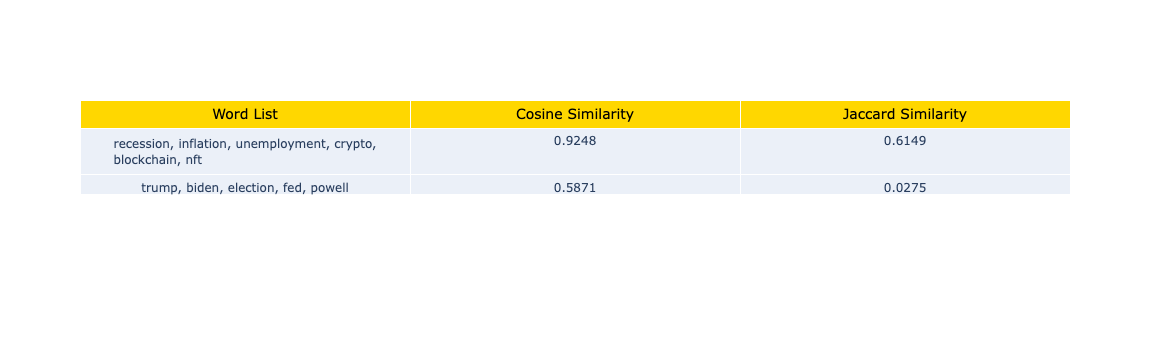

In [89]:
schema = StructType([
    StructField("Word List", StringType(), True),
    StructField("Cosine Similarity", DoubleType(), True),
    StructField("Jaccard Similarity", DoubleType(), True)
])

# Create the DataFrame with the defined schema
df_title = spark.createDataFrame([(", ".join(word_list_econ), float(cosine_sim_econ_grouped_subreddits_title), float(jaccard_index_econ_grouped_subreddits_title)), 
                                  (", ".join(word_list_pol), float(cosine_sim_pol_grouped_subreddits_title), float(jaccard_index_pol_grouped_subreddits_title))
                                  ],
                                  schema)

# round numeric cols
df_title = df_title.withColumn("Cosine Similarity", f.round(df_title["Cosine Similarity"], 4))
df_title = df_title.withColumn("Jaccard Similarity", f.round(df_title["Jaccard Similarity"], 4))

# convert to pandas for plotly
df_title = df_title.toPandas()

# create plotly datatable
fig = go.Figure(data=go.Table(
    header=dict(
        values=list(df_title.columns),
        fill_color='gold',
        align='center',
        font=dict(size=14, color='black')
    ),
    cells=dict(values=[df_title[col] for col in df_title.columns], align='center')
))

fig.show();

# save as html
pio.write_html(fig, file='../../data/plots/title_cosine_jaccard.html')

# save df as pandas and export as csv
df_title.to_csv('../../data/csv/title_cosine_jaccard.csv', index=False)

## Final Table - Submission Body Cosine Sim & Jaccard Index

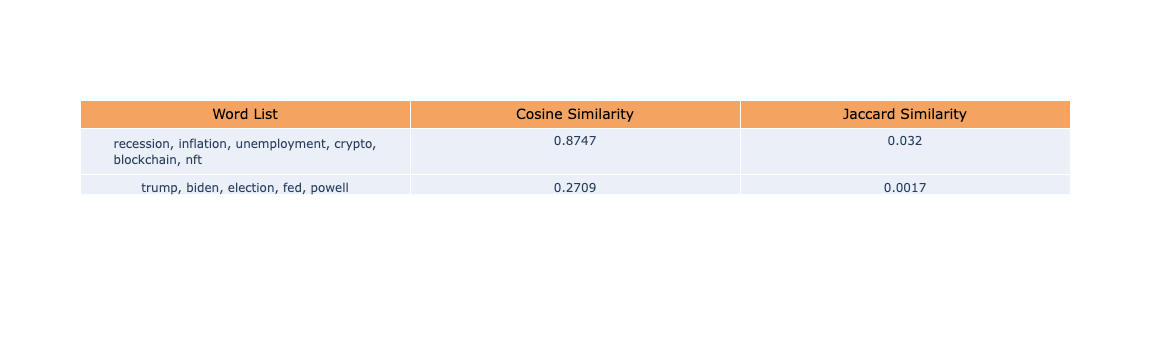

In [93]:
schema = StructType([
    StructField("Word List", StringType(), True),
    StructField("Cosine Similarity", DoubleType(), True),
    StructField("Jaccard Similarity", DoubleType(), True)
])

# Create the DataFrame with the defined schema
df_body = spark.createDataFrame([(", ".join(word_list_econ), float(cosine_sim_econ_grouped_subreddits_body), float(jaccard_index_econ_grouped_subreddits_body)), 
                                  (", ".join(word_list_pol), float(cosine_sim_pol_grouped_subreddits_body), float(jaccard_index_pol_grouped_subreddits_body))],
                                  schema)

# round numeric cols
df_body = df_body.withColumn("Cosine Similarity", f.round(df_body["Cosine Similarity"], 4))
df_body = df_body.withColumn("Jaccard Similarity", f.round(df_body["Jaccard Similarity"], 4))

# convert to pandas for plotly
df_body = df_body.toPandas()

# create plotly datatable
fig = go.Figure(data=go.Table(
    header=dict(
        values=list(df_body.columns),
        fill_color='#F4A460',
        align='center',
        font=dict(size=14, color='black')
    ),
    cells=dict(values=[df_body[col] for col in df_body.columns], align='center')
))

fig.show();

# save as html
pio.write_html(fig, file='../../data/plots/body_cosine_jaccard.html')

# save df as pandas and export as csv
df_body.to_csv('../../data/csv/body_cosine_jaccard.csv', index=False)

## Reformat Tables

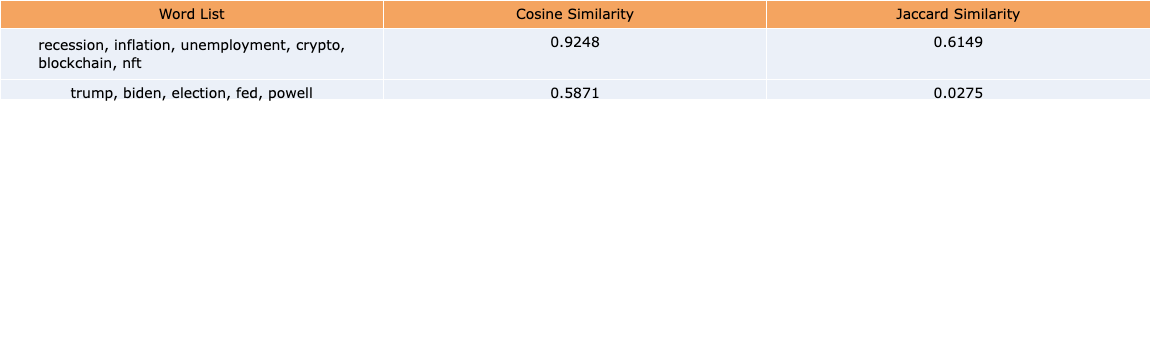

In [24]:
df_title = pd.read_csv("../../data/csv/title_cosine_jaccard.csv")

# create plotly datatable
fig = go.Figure(data=go.Table(
    header=dict(
        values=list(df_title.columns),
        fill_color='#F4A460',
        align='center',
        font=dict(size=14, color='black')
    ),
    cells=dict(
        values=[df_title[col] for col in df_title.columns], 
        align='center',
        font=dict(size=14, color='black'),
    )
))
fig.update_layout(width=350, height=265, margin={"l":0,"r":0,"t":0,"b":0})

fig.show();

# save as html
pio.write_html(fig, file='../../data/plots/title_cosine_jaccard.html')

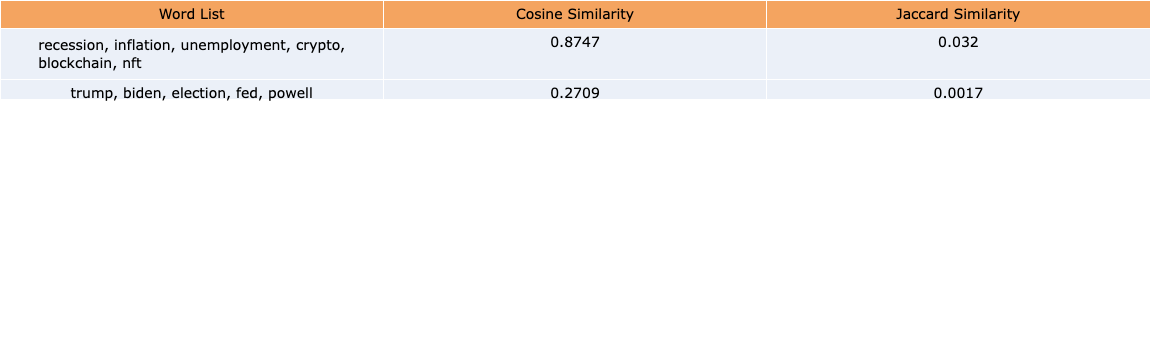

In [25]:
df_body = pd.read_csv("../../data/csv/body_cosine_jaccard.csv")

# create plotly datatable
fig = go.Figure(data=go.Table(
    header=dict(
        values=list(df_body.columns),
        fill_color='#F4A460',
        align='center',
        font=dict(size=14, color='black')
    ),
    cells=dict(
        values=[df_body[col] for col in df_body.columns], 
        align='center',
        font=dict(size=14, color='black')
    )
))
fig.update_layout(width=350, height=265, margin={"l":0,"r":0,"t":0,"b":0})

fig.show();

# save as html
pio.write_html(fig, file='../../data/plots/body_cosine_jaccard.html')